# **자연어 8일 - UnSupervised Learning**
- **True Value** 가 특정되지 않았을 때
- Label Target 값들이 특정되지 않았을 때
- https://ini.korea.ac.kr/colleagues/ (gon0121@naver.com : 땅콩곤두 (류기곤))

# **K-Means 실습 - > EM Algorithm 을 활용 합니다**
- 단어들을 **Concept 벡터** 위에서 **재배치 (Clustering)** 를 합니다.
- **Latent (Hidden) Factors** (주제별 공통된 단어를 사용 할 것이다)
- similarity : Cosin Angle **(ex: TF-IDF)**
- Setup **K** numbere of **centroids**

## **1 난수 데이터를 생성합니다** 
randrange(1,100) : 1 ~ 100 사이 중 난수값 1개 생성

In [1]:
N    = 100 # Point 갯수
data = []  # 난수로 데이터 저장

# 0 ~ 99 사이의 난수를 생성
from random import randrange, seed
seed(0) # 일정한 난수값 생성

for _ in range(N):
    data.append((randrange(1,100),(randrange(1,100))))
data[:5]    

[(50, 98), (54, 6), (34, 66), (63, 52), (39, 62)]

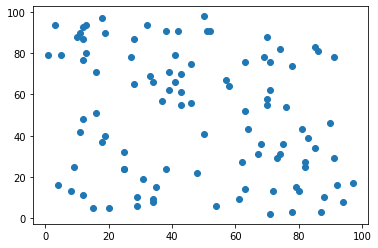

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
X = [_[0]  for _ in data]
Y = [_[1]  for _ in data]
plt.scatter(X, Y)
plt.show()

In [3]:
# K-means 중심점 임의로 만들기
K     = 4
means = []
for _ in range(K):
    means.append((randrange(1,100),(randrange(1,100))))
means

[(45, 56), (24, 8), (65, 60), (6, 77)]

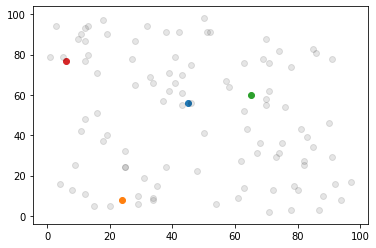

In [4]:
# color Map 적용하기
colorMap = ["C0", "C1","C2","C3","C4","C5", "C6", "C7", "C8","C9", "k"]
# K 중심포인트 그리기
for i, centroid in enumerate(means):
    plt.scatter(centroid[0], centroid[1], color=colorMap[i])
# 100 개의 포인트 그리기
plt.scatter(X, Y, color=colorMap[-1], edgecolors=colorMap[-1], alpha=.1)
plt.show()

## **2 K-means 분류 모델링**
**KNN** 과 **K-means** 의 차이점을 분명히 알자 (KNN 알고리즘은 추후 책으로 보완하기)
1. **KNN :** 특정한 **K** 를 지정하면(Supervised), 투표를 통해 분류합니다. 주의할 점으로 K는 홀수개를 추천 합니다.
1. **K-Means :** 분할된 클러스터의 **내부 데이터를 거리가 가까운 순서대로** 묶습니다.

In [5]:
# 유클리드 거리측정 함수
from math import sqrt
def distance(x1, x2):
    _sum = .0
    for _x1, _x2 in zip(x1, x2):
        _sum += (_x1 - _x2)**2
    return sqrt(_sum)

# (K=3) 3개의 분류 기준점 최소거리 인덱스
def expectation(d, means):
    dist = []
    for centroid in means:
        dist.append(distance(d, centroid))
    return dist.index(min(dist)) # 최소 거리를 갖는 분류를 라벨링

# r_nk : 3개의 K 기준 Point를 기준으로 데이터 분류
import numpy as np
r_nk = [ list(np.zeros(K))  for _ in range(N)]
for i, d in enumerate(data):
    j = expectation(d, means)
    r_nk[i][j] = 1
r_nk[:3]

[[0.0, 0.0, 1, 0.0], [0.0, 1, 0.0, 0.0], [1, 0.0, 0.0, 0.0]]

## **3 손실함수(J)를 활용한 왜곡의 측정(Distortion Measure)**
**임의의 K** 를 기준으로 **분류된 모델의 Error ( $ J =  \Sigma^N \Sigma^K r_{nk} || X_n - \mu_k ||^2 $ ) 를** 평가 합니다.
1. **손실함수(J)** 값을 측정하고, 다시 **임의의 K점을** 찾은뒤 **다시 손실함수(J) 로 분류내용을 평가** 합니다.

In [6]:
# r_nk 는 {0,1} 의 값을 갖습니다.
# 위에서 생성한 r_nk 벡터에서 1의 값을 갖는 차원값을 추출 합니다
def maximization(Dk):
    C   = len(Dk)   # 개별 클러스터 분류된 갯수
    dim = len(Dk[0])
    
    # 클러스터 분류 데이터 갯수가 0인 경우
    if C == 0:
        return list(np.zeros(dim))

    # 유효한 분류내용이 있는경우 
    _sum = list(np.zeros(dim))
    for d in Dk:
        for i in range(dim):
            _sum[i] += d[i]            
    return [_/C   for _ in _sum]

In [7]:
newMeans = []
for j, centroid in enumerate(means):
    Dk = [_ for i, _ in enumerate(data)
            if  r_nk[i][j] == 1]
    newMeans.append(maximization(Dk))
    print("{} : data length {}".format(centroid, len(Dk)))
newMeans

(45, 56) : data length 16
(24, 8) : data length 23
(65, 60) : data length 41
(6, 77) : data length 20


[[39.0, 64.0],
 [33.30434782608695, 14.73913043478261],
 [74.90243902439025, 48.26829268292683],
 [15.45, 80.5]]

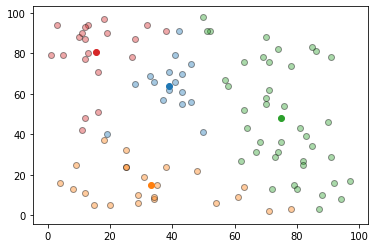

In [8]:
for i, (x, y) in enumerate(zip(X, Y)):
    plt.scatter(x, y, color=colorMap[r_nk[i].index(1)],
                edgecolors=colorMap[-1], alpha=.4)
for i , centroid in enumerate(newMeans):
    plt.scatter(centroid[0], centroid[1],
                edgecolors=colorMap[i], color=colorMap[i])
plt.show()

## **4 Expectation Maximization algorithm (기댓값 최대화 알고리즘)**
1. **손실함수(J)를 반복 측정하며** 최적의 분류를 찾습니다
1. 분류과정을 반복하면 **손실함수(J) 의 값이 줄어드는 모습을** 볼 수 있습니다.

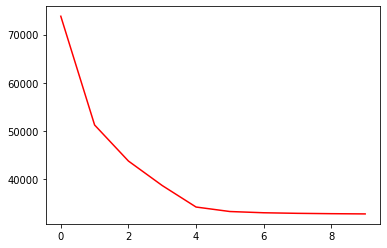

In [9]:
# 손실함수 J
def sse(Dk, centoid, _sum = .0): 
    for d in Dk:
        _sum += distance(d, centroid)**2
    return _sum

sseList = [] # 반복학습을 기록할 객체
for _ in range(10):
    r_nk  = [list(np.zeros(K))  for _ in range(N)]
    for i, d in enumerate(data):
        j = expectation(d, means) # K 중심 데이터 모으기
        r_nk[i][j] = 1

    _sum, newMeans = 0.0, []
    for j, centroid in enumerate(means):
        Dk = [_  for i, _ in enumerate(data)
                 if  r_nk[i][j] == 1]
        newMeans.append(maximization(Dk)) # 손실함수 J 로 보정하기
        _sum += sse(Dk, centroid)
    sseList.append(_sum)
    means = newMeans # means 값을 보정 후 반복의 시작

# 반복학습을 기록할 객체
plt.plot(range(len(sseList)), sseList, "r-")

## **5 최적의 EM 값 반복학습 및 시각화**
**임의의 K** 를 기준으로 **분류된 모델의 Error ( $ J =  \Sigma^N \Sigma^K r_{nk} || X_n - \mu_k ||^2 $ ) 를** 평가 합니다.
1. **sseList** 내용 확인결과 **n=4** 을 최적분류 기준으로 활용가능
1. 지금까지의 내용을 바탕으로 반복학습시 분류의 변화를 확인합니다

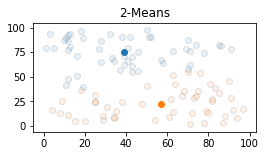

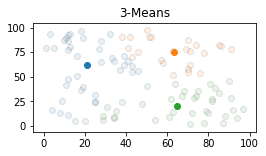

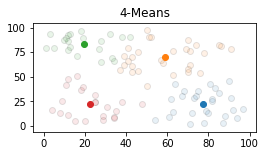

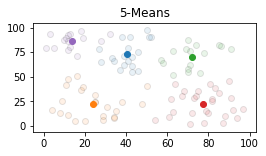

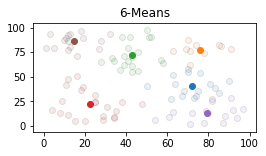

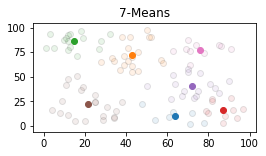

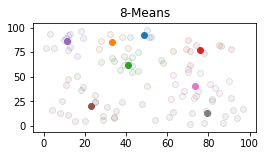

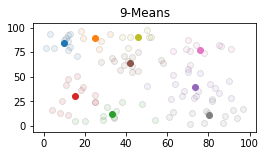

In [10]:
sseList = {}

# K = {2,10} 마다 10번씩 반복분류 실행
for K in range(2,10):
    means = [ (randrange(1,100), randrange(1,100))  
              for _ in range(K) ]

    for _ in range(10):
        r_nk = [list(np.zeros(K))  for _ in range(N)]
        for i, d in enumerate(data):
            j = expectation(d, means)
            r_nk[i][j] = 1

        _sum     = .0
        newMeans = []
        for j, centroid in enumerate(means):
            Dk = [_ for i, _ in enumerate(data)
                    if  r_nk[i][j] == 1]
            newMeans.append(maximization(Dk))
            _sum += sse(Dk, centroid)        
        means = newMeans
    sseList[K] = _sum

    # K 갯수를 확대하며 분류 내용을 확인 합니다.
    plt.figure(figsize = (4,2))
    for i, (x, y) in enumerate(zip(X, Y)):
        plt.scatter(x, y, alpha = .1, 
                    edgecolors = colorMap[-1], color = colorMap[r_nk[i].index(1)])
    for i , centroid in enumerate(newMeans):
        plt.scatter(centroid[0], centroid[1],
                    edgecolors = colorMap[i], color = colorMap[i])
    plt.title("{0}-Means".format(K))
    plt.show() 

# **K-Means 실습 2 - Cosine 분류의 활용**
1. **K** 중심포인트와 거리를 측정하여 분류하였습니다.
1. SSE 분석을 **Cosine** 유사도를 활용하여 분류 합니다

## **1 난수 데이터를 생성합니다** 
randrange(1,100) : 1 ~ 100 사이 중 난수값 1개 생성

In [11]:
K = 3
N = 100
from random import randrange
data  = [ (randrange(1,100),randrange(1,100)) for _ in range(N) ]
means = [ (randrange(1,100),randrange(1,100)) for _ in range(K) ]
X     = [_[0] for _ in data]
Y     = [_[1] for _ in data]

## **2 원점에서 각도를 기준으로 데이터를 분류** 
1. 앞에서는 유클리드 거리함수를 활용하여 최소값의 묶음을 정리하였습니다
1. 이번에는 Cosine 각도를 측정하여 유사도 분류를 실시 합니다

In [12]:
# 유클리드 거리측정 함수
from math import sqrt
def distance(x1, x2):
    _sum = 0.0
    for _x1, _x2 in zip(x1, x2):
        _sum += (_x1-_x2)**2
    return sqrt(_sum)

# 원점에서 두 점 사이의 각도를 측정
def angle(x1, x2):
    innerProduct = .0  # 측정기준 원점의 설정
    for _x1, _x2 in zip(x1, x2): 
        innerProduct += (_x1 * _x2)
    x1Length = distance(x1, [.0 for _ in range(len(x1))])
    x2Length = distance(x2, [.0 for _ in range(len(x2))])
    return innerProduct / (x1Length * x2Length)

# 유클리드 거리의 최소특정과 달리, 최댓값을 특정 합니다
def expectation(d, means):
    dist = [angle(d, centroid) for centroid in means]
    return dist.index(max(dist))

In [13]:
r_nk = list(list(0 for _ in range(K)) for _ in range(N))
for i, d in enumerate(data):
    j = expectation(d, means)
    r_nk[i][j] = 1

r_nk[:10][:5]

[[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]]

## **3 손실함수(J)를 활용한 왜곡의 측정(Distortion Measure)**
**임의의 K** 를 기준으로 **분류된 모델의 Error ( $ J =  \Sigma^N \Sigma^K r_{nk} || X_n - \mu_k ||^2 $ ) 를** 평가 합니다.
1. **손실함수(J)** 값을 측정하고, 다시 **임의의 K점을** 찾은뒤 **다시 손실함수(J) 로 분류내용을 평가** 합니다.

In [14]:
# 손실함수 J 
def _sse(Dk, centoid): 
    _sum = 0.0
    for d in Dk:
        _sum += angle(d, centroid)
    return _sum

sseList = [] # 반복학습을 기록할 객체
import numpy as np
for _ in range(10):
    r_nk  = [list(np.zeros(K))  for _ in range(N)]
    for i, d in enumerate(data):
        j = expectation(d, means) # K 중심 데이터 모으기
        r_nk[i][j] = 1

    _sum, newMeans = 0.0, []
    for j, centroid in enumerate(means):
        Dk = [_  for i, _ in enumerate(data)
                 if  r_nk[i][j] == 1]
        newMeans.append(maximization(Dk)) # 손실함수 J 로 보정하기
        _sum += _sse(Dk, centroid)
    sseList.append(_sum)
    means = newMeans # means 값을 보정 후 반복의 시작

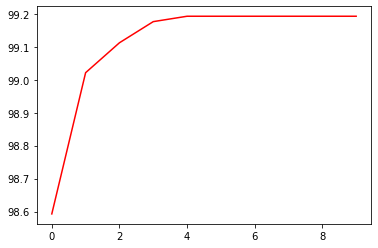

In [15]:
%matplotlib inline
# 반복학습을 기록할 객체
import matplotlib.pyplot as plt
plt.plot(range(len(sseList)), sseList, "r-")

## **4 Expectation Maximization algorithm (기댓값 최대화 알고리즘)**
1. **손실함수(J)를 반복 측정하며** 최적의 분류를 찾습니다
1. 분류과정을 반복하면 **손실함수(J) 의 값이 줄어드는 모습을** 볼 수 있습니다.

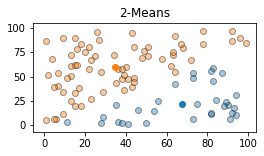

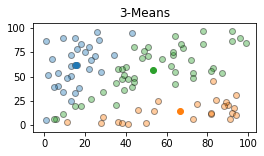

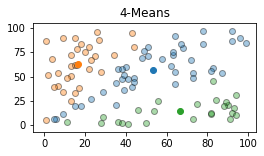

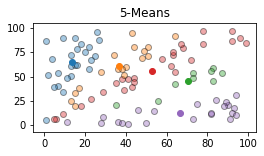

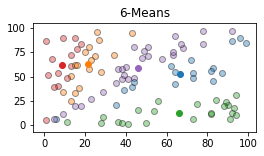

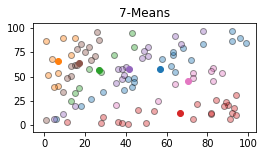

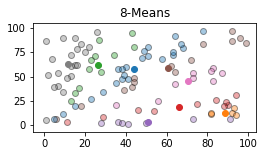

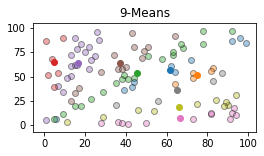

In [16]:
# K = {2, 10}
sseList = []
for K in range(2,10):
    means = [] # Means 중심점 구하기
    for _ in range(K):
        means.append((randrange(1,100), randrange(1,100)))
    
    for _ in range(10):
        r_nk = [list(np.zeros(K))  for _ in range(N)]
        for i, d in enumerate(data):
            j = expectation(d, means)
            r_nk[i][j] = 1
        _sum     = .0
        newMeans = []
        for j, centroid in enumerate(means):
            Dk = [_ for i, _ in enumerate(data)
                    if  r_nk[i][j] == 1]
            if len(Dk) == 0:
                pass
            else:
                newMeans.append(maximization(Dk))
                _sum += _sse(Dk, centroid)        
        means = newMeans
    sseList.append(_sum)
    
    plt.figure(figsize = (4,2))
    for i, (x, y) in enumerate(zip(X, Y)):
        plt.scatter(x, y, color=colorMap[r_nk[i].index(1)],
                    edgecolors=colorMap[-1], alpha=.4)
    for i , centroid in enumerate(newMeans):
        plt.scatter(centroid[0], centroid[1],
                    edgecolors=colorMap[i], color=colorMap[i])
    plt.title("{0}-Means".format(K))
    plt.show()